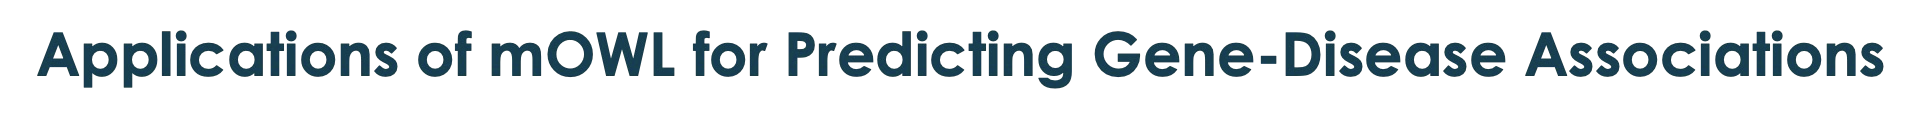

**mOWL Input dataset:** ontology in OWL format

**Methods input:** takes vectors of genes and diseases 

**Output:** predict gene-disease association using cosine similarity


In [ ]:
#Install the tool using: 
! pip install mowl-borg 

In [48]:
from google.colab import drive
drive.mount('/content/drive/')
#cd /content/drive/MyDrive/mowl-tutorial/
import os
os.chdir("/content/drive/MyDrive/mowl-tutorial/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# built-in imports
import sys
import mowl
mowl.init_jvm("4g")
import torch as th
import logging
import numpy as np
import pickle as pkl
from mowl.visualization.base import TSNE
import matplotlib.pyplot as plt
from mowl.projection.edge import Edge
from mowl.datasets.builtin import GDADataset, GDAHumanDataset, GDAMouseDataset
from pykeen.models import TransE,ConvE,DistMult,TransR,TransD
from mowl.projection.dl2vec.model import DL2VecProjector 
from mowl.kge import KGEModel
from mowl.evaluation.rank_based import EmbeddingsRankBasedEvaluator
from mowl.evaluation.base import TranslationalScore, CosineSimilarity
from mowl.projection.factory import projector_factory, PARSING_METHODS
from mowl.walking import DeepWalk
from gensim.models.word2vec import LineSentence
import gensim
from gensim.models import Word2Vec
from mowl.evaluation.rank_based import EmbeddingsRankBasedEvaluator
from mowl.evaluation.base import CosineSimilarity
from mowl.projection import TaxonomyWithRelationsProjector
from mowl.projection.edge import Edge

import warnings  
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim') 

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Dataset 

Build your own dataset

In [6]:
from mowl.ontology.extend import insert_annotations
 
diseases_annotations = ("diseases_annot.tsv", "http://has_annotation", True) 
genes_annotations = ("genes_annot.tsv", "http://has_annotation", True) 
gene_disease_associations = ("gene_disease_associations.tsv","http://is_associated_with/", True) 

annotations = [diseases_annotations , genes_annotations, gene_disease_associations] # There could be more than 1 annotations file. 

insert_annotations("upheno.owl", annotations, out_file = "upheno_with_annotations.owl" )


Use the Built-in Dataset

In [7]:
dataset = GDAMouseDataset()

The dataset will be downloaded to a folder name `gda_mouse` with the training, validation and testing ontology dataset

In [8]:
! ls gda_mouse/

ontology.owl  test.owl	valid.owl


# Graph-based embeddings

 ### Example for two methods: DL2vec and Owl2vec* methods

<font color='blue'><font size="4">1) DL2vec Prediction Method </font></font>


1. **Projecting the ontology** 
- Project the ontology using the DL2Vec Projector class, with the specific rules used to project the ontology. 
- The outcome of the projection algorithm is an edgelist.



In [9]:
from mowl.projection.dl2vec.model import DL2VecProjector 
projector = DL2VecProjector(True)
train_edges = projector.project(dataset.ontology)
test_edges = projector.project(dataset.testing)

2. **Generating random walks**
- The random walks are generated using the DeepWalk.


In [ ]:
walker = DeepWalk(10, # number of walks per node
                  10, # walk length
                  0.1, # restart probability
                  workers=4, outfile = 'walk',seed=40) # number of threads

walks = walker.walk(train_edges)
walks_file = walker.outfile
sentences = LineSentence(walks_file)

3. **Training the Word2Vec model**
- To train the Word2Vec model, we rely on the Gensim library

In [11]:
model = Word2Vec(sentences, vector_size=100, epochs = 2, window=5, min_count=1, workers=10)


4. **Evaluating the embeddings** 
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [13]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cpu')


evaluator.evaluate(show=True)

100%|██████████| 371/371 [00:05<00:00, 68.62it/s] 

Hits@1:   0.00 Filtered:   0.00
Hits@10:  0.05 Filtered:   0.07
Hits@100: 0.47 Filtered:   0.47
MR:       1210.28 Filtered: 1206.76
AUC:      0.86 Filtered:   0.86
Evaluation finished. Access the results using the "metrics" attribute.


In [14]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

print(f'Number of the disease is {len(human_disease)}, and number of genes is {len(mouse_genes)}')

Number of the disease is 8383, and number of genes is 14048


In [15]:
human_disease[:10]

['http://OMIM_181500',
 'http://OMIM_601371',
 'http://OMIM_601665',
 'http://OMIM_222100',
 'http://OMIM_114480',
 'http://OMIM_614286',
 'http://OMIM_270150',
 'http://OMIM_603694',
 'http://OMIM_166710',
 'http://OMIM_601407']

In [16]:
mouse_genes[:10]

['http://17926',
 'http://11540',
 'http://11789',
 'http://111507',
 'http://20928',
 'http://14464',
 'http://13717',
 'http://19211',
 'http://56318',
 'http://16653']

In [17]:
human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

print(f"The dimentions of this matrix is {similarity.shape}")


The dimentions of this matrix is (8383, 14048)


## Evaluating the predictions to find the most similar genes:

In [18]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

#associations from MGI_DO.rpt

#OMIM_181500 : schizophrenia : DOID:5419	OMIM:181500	mouse, laboratory	10090	Magi2	50791	MGI:1354953
disease_id = 'http://OMIM_181500' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')
      

#OMIM_615643 : neurodegeneration with brain iron accumulation 6
#DOID:0110740	OMIM:615643	mouse, laboratory	10090	Coasy	71743	MGI:1918993
disease_id = 'http://OMIM_615643' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

      
#DOID:0080449	developmental and epileptic encephalopathy 16	OMIM:615338	mouse, laboratory	10090	Tbc1d24	224617	MGI:2443456
disease_id = 'http://OMIM_615338' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

      
#DOID:0080436	developmental and epileptic encephalopathy 4	OMIM:612164	human	9606	STXBP1	6812	
#DOID:0060309	syndromic X-linked intellectual disability		human	9606	HNRNPH2	3188	
#HNRNPH2	3188	Hnrnph2	MGI:1201779	MP:0001186, MP:0005386, MP:0010771	      
disease_id = 'http://OMIM_612164' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')



The most similar gene to disease OMIM_181500 are: ['http://17295', 'http://14585', 'http://15979', 'http://94109', 'http://54140']
The most similar gene to disease OMIM_615643 are: ['http://54636', 'http://71743', 'http://236690', 'http://232975', 'http://22139']
The most similar gene to disease OMIM_615338 are: ['http://13409', 'http://17257', 'http://70061', 'http://50873', 'http://12810']
The most similar gene to disease OMIM_612164 are: ['http://22834', 'http://102723680', 'http://201292', 'http://57332', 'http://19378']


-------------------------------------

# Task 1 : 

<div class="alert alert-block alert-success"> 

<font size="4"> 
    Predict the <font color='SteelBlue'>top 10 similar genes</font> to 
    diabetes mellitus disease OMIM ID: <font color='Tomato'>http://OMIM_608036</font>
    using <font color='red'>OWL2vec*</font> prediction method

</font>

</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> Follow the <b>TODO</b> interactions to modify the script, and the rest should be the same you just need to run the cell to execute the code.
</div>


----

<font color='blue'><font size="4">2) OWL2vec* Prediction Method </font></font> 


1. **Projecting the ontology** 
- Project the ontology using the OWL2Vec* Projector class, with the specific rules used to project the ontology. 
- The outcome of the projection algorithm is an edgelist.


In [ ]:
from mowl.projection import #TODO: import the appropriate function (refer to https://mowl.readthedocs.io/en/latest/api/projection/index.html)
dataset = GDAMouseDataset()
projector = OWL2VecStarProjector(True)
train_edges = projector.project(dataset.ontology)
test_edges = projector.project(dataset.testing)

2. **Generating random walks**
- The random walks are generated using the DeepWalk.


In [ ]:
walker = DeepWalk( ,#TODO: add the number of walks per node
                   ,#TODO: add the walk length
                  workers=4, # number of threads
                  outfile = , #TODO: add the name of the output file for the walks
                  seed=40) #fix the random seed 

walks = walker.walk(train_edges)
walks_file = walker.outfile
sentences = LineSentence(walks_file)

3. **Training the Word2Vec model**
- To train the Word2Vec model, we rely on the Gensim library

In [ ]:
model = Word2Vec(sentences, 
                 vector_size= , #TODO: add the size of the vector
                 epochs = ,     #TODO: update the number of training epochs
                 window=5, min_count=1, workers=10)


4. **Evaluating the embeddings** 
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cuda')

evaluator.evaluate(show=True)

In [ ]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

print(f'Number of the disease is {len(human_disease)}, and number of genes is {len(mouse_genes)}')

In [ ]:
human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

print("the dimentions of this matrix is ", similarity.shape)


## Evaluating the predictions to find the most similar genes:

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

  

disease_id = #TODO: write the disease OMIM ID

number_of_genes =  #TODO: number of genes to be ranked

top_k = find_similar_genes( , #TODO: disease OMIM ID
                            , #TODO: number of genes 
                           similarity, 
                           human_disease, 
                           mouse_genes)

print(f'The top {number_of_genes} most similar gene to disease {disease_id.split("/")[2]} are:')

for idx, genes in enumerate(top_k):
    print(f" Gene in Rank {idx+1} is : {top_k[idx]}")
    

----------------------------------------

# Syntactic embeddings

In [19]:
from mowl.corpus import extract_and_save_axiom_corpus
from mowl.owlapi import OWLAPIAdapter
from mowl.reasoning import MOWLReasoner
from org.semanticweb.elk.owlapi import ElkReasonerFactory
from java.util import HashSet
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
import os

<font color='blue'><font size="4">1) Onto2Vec Prediction Method </font></font> 


This example corresponds to the paper **Onto2Vec: joint vector-based representation of biological entities and their ontology-based annotations**.

This method is an approach to learn numerical representations (embeddings) of (biomedical) ontologies by representing ontology axioms as text sequences and applying an unsupervised learning algorithm such as Word2Vec. Onto2Vec uses an ontology reasoner to infer new axioms as a preprocessing step. The algorithm is tested on the protein-protein interaction task.

For this algorithm, we need three components:

1. The reasoner

2. The corpus generator

3. The Word2Vec model

 
**1) Inferring new axioms**

- Onto2Vec uses an ontology reasoner to infer new axioms as a preprocessing step. In the original paper, the authors used the HermiT reasoner. For this example, we use the ELK reasoner.


In [20]:
reasoner_factory = ElkReasonerFactory()
reasoner = reasoner_factory.createReasoner(dataset.ontology)
mowl_reasoner = MOWLReasoner(reasoner)


In [21]:
# %%
# We wrap the reasoner into the :class:`MOWLReasoner <mowl.reasoning.base.MOWLReasoner>` class \
# in order to use some shortcuts the mOWL
# provides such as:
#
# - inferring subclass axioms
# - inferring equivalent class axioms
# - inferring disjoint axioms (not applicable for this example since we use ELK reasoner)

classes = dataset.ontology.getClassesInSignature()
subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes)
equivalent_class_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes)

# %%
# We can now add the inferred axioms to the ontology.

adapter = OWLAPIAdapter()
manager = adapter.owl_manager

axioms = HashSet()
axioms.addAll(subclass_axioms)
axioms.addAll(equivalent_class_axioms)

manager.addAxioms(dataset.ontology, axioms)

<java object 'org.semanticweb.owlapi.model.parameters.ChangeApplied'>

**2- The corpus generator**

In [22]:
extract_and_save_axiom_corpus(dataset.ontology, "onto2vec_corpus.txt")

**3- Generating the corpus and training the model**
- Now that we have an extended ontology, we can generate the corpus out of it. After that, we can train the Word2Vec model.


In [23]:
sentences = LineSentence("onto2vec_corpus.txt")
model = Word2Vec(sentences, vector_size=5, window=2, min_count=1, workers=4)

# %%
# Cleaning up memory
# os.remove("onto2vec_corpus.txt")

## Evaluating the embeddings
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [24]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cpu')

evaluator.evaluate(show=True)

100%|██████████| 371/371 [00:12<00:00, 29.27it/s] 

Hits@1:   0.01 Filtered:   0.03
Hits@10:  0.15 Filtered:   0.18
Hits@100: 0.37 Filtered:   0.37
MR:       2116.04 Filtered: 2112.49
AUC:      0.75 Filtered:   0.75
Evaluation finished. Access the results using the "metrics" attribute.


In [25]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

disease_id = 'http://OMIM_612164' 
top_k = find_similar_genes(disease_id, 1 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')


The most similar gene to disease OMIM_612164 are: ['http://84823']


----

# Task 2 : 

<div class="alert alert-block alert-success"> 

<font size="4"> 
    Predict the <font color='SteelBlue'>top 5 similar genes</font> to 
    diabetes mellitus disease OMIM ID: <font color='Tomato'>http://OMIM_608036</font>
    using <font color='red'>OPA2Vec*</font> prediction method

</font>

</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Follow the <b>TODO</b> interactions to modify the script, and the rest should be the same you just need to run the cell to execute the code.
</div>


--- 

<font color='blue'><font size="4">2) OPA2Vec Prediction Method </font></font> 


This example corresponds to the paper **OPA2Vec: combining formal and informal content of biomedical ontologies to improve similarity-based prediction**.

This method is an extension of **Onto2Vec** that apart from formal knowldege (i.e. axioms) it also uses informal knowledge such as entity metadata (i.e. synonyms, definitions, etc.)

For this algorithm, we need four components:

1.  The reasoner

2. The corpus generator

<font color='red'>3. The annotations generator</font> 

4. The Word2Vec model

In [ ]:
from mowl.corpus import extract_and_save_axiom_corpus
from mowl.owlapi import OWLAPIAdapter
from mowl.reasoning import MOWLReasoner
from org.semanticweb.elk.owlapi import ElkReasonerFactory
from java.util import HashSet
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
import os
from sklearn.metrics.pairwise import cosine_similarity

from mowl.corpus import extract_and_save_axiom_corpus, extract_and_save_annotation_corpus
# OPA2Vec use annotation so we need to import extract_and_save_annotation_corpus


**1) Inferring new axioms**

- OPA2Vec uses an ontology reasoner to infer new axioms as a preprocessing step. In the original paper, the authors used the HermiT reasoner. For this example, we use the ELK reasoner.



In [ ]:
reasoner_factory = ElkReasonerFactory()
reasoner = reasoner_factory.createReasoner(dataset.ontology)
mowl_reasoner = MOWLReasoner(reasoner)

We wrap the reasoner into the **MOWLReasoner** class in order to use some shortcuts the mOWL provides such as:

- inferring subclass axioms

- inferring equivalent class axioms

- inferring disjoint axioms (not applicable for this example since we use ELK reasoner)


In [ ]:
classes = dataset.ontology.getClassesInSignature()
subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes)
equivalent_class_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes)

We can now add the inferred axioms to the ontology:

**2- The corpus generator**

In [ ]:
adapter = OWLAPIAdapter()
manager = adapter.owl_manager

axioms = HashSet()
axioms.addAll(subclass_axioms)
axioms.addAll(equivalent_class_axioms)

manager.addAxioms(dataset.ontology, axioms)

In [ ]:
extract_and_save_axiom_corpus(dataset.ontology, "opa2vec_corpus.txt")

<font color='red'> **3- The annotations generator**</font>

In [ ]:
#TODO : extract and save the annotations (dataset.ontology, "opa2vec_corpus.txt", mode="a")


**4- Generating the corpus and training the model**
- Now that we have an extended ontology, we can generate the corpus out of it. After that, we can train the Word2Vec model.



In [ ]:
sentences = LineSentence("opa2vec_corpus.txt")

model = Word2Vec(sentences, 
                 vector_size= , #TODO: add the size of the vector
                 epochs = ,     #TODO: update the number of training epochs
                 window=5, min_count=1, workers=10)


## Evaluating the embeddings

In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

eval_train_edges = projector.project(dataset.ontology)
eval_test_edges = projector.project(dataset.testing)
    
vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    eval_test_edges,
    CosineSimilarity,
    training_set=eval_train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cpu')

evaluator.evaluate(show=True)

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes


vectors = model.wv


human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if 'http://' in classes and classes[7:].isnumeric():
        mouse_genes.append(classes)

human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))


In [ ]:
disease_id =  #TODO: write the disease OMIM ID

number_of_genes = #TODO: number of genes to be ranked

top_k = find_similar_genes( , #TODO: disease OMIM ID
                            , #TODO: number of genes 
                           similarity, 
                           human_disease, 
                           mouse_genes)

print(f'The top {number_of_genes} most similar gene to disease {disease_id.split("/")[2]} are:')

for idx, genes in enumerate(top_k):
    print(f" Gene in Rank {idx+1} is : {top_k[idx]}")
    

------

# Ontologies and Text-mining

Genes and Diseases extracted from text using the exact match, refer to the notebook [Ontologies_and_text_mining](https://github.com/bio-ontology-research-group/mowl-tutorial/blob/main/notebooks/02_Ontologies_and_text_mining.ipynb), to see how the model trained, and for more details refer to the presentation [Ontologies and Text-mining](https://github.com/bio-ontology-research-group/mowl-tutorial/blob/main/slides/Ontologies%20and%20text%20mining.pdf).


In [27]:
from gensim.models import Word2Vec
import pickle as pkl
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


In [41]:
# Collect the vectors for the genes and diseases
word2vec_file = 'w2v_model/wv_model'
vectors = Word2Vec.load(word2vec_file)

human_disease=[]
mouse_genes=[]
for classes in vectors.wv.index_to_key:
    if 'OMIM_' in classes:
        human_disease.append(classes)
    if 'http://' in classes and classes[7:].isnumeric():
        mouse_genes.append(classes)

human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors.wv[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors.wv[k])

similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))


## Evaluating the predictions to find the most similar genes:

In [42]:
# Evaluating the similarity

def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

disease_id = 'http://OMIM_114500' 
# DOID:9256	colorectal cancer	OMIM:114500	human	9606	KDR	3791	


top_k = find_similar_genes(disease_id, 10 ,similarity, human_disease, mouse_genes )
print(f'The most similar genes to disease {disease_id.split("/")[2]} are:')
for i, j in enumerate(top_k):
    print(i+1, j)     

# The linked genes at rank 7

The most similar genes to disease OMIM_114500 are:
1 http://4838
2 http://5045
3 http://572
4 http://4942
5 http://5805
6 http://5064
7 http://3791
8 http://6418
9 http://55806
10 http://22944
